# SVM and GDA for CIFAR-10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC

from scipy.spatial.distance import cdist

# The CIFAR10 dataset
- Download and normalize the CIFAR10 dataset from torchvision
- Split the CIFAR10 data into train, validation and test set
- Set the batch size for processing these datasets
- Build the dataloaders for train, validation, and test set which will be used in the training loop
- Define the string class labels (targets are numeric 0-9)

In [2]:
# mean and std for the RGB channels in CIFAR10
tmean = [0.49139968, 0.48215841, 0.44653091]
tstd = [0.24703223, 0.24348513, 0.26158784]

# transform the 32x32x3 images into a tensor after normalizing
# each channel using the parameters above
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(tmean, tstd)])

# download and transform the  trainset and testset for training
trainset = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

#split trainset into a train and a val set (90-10 split)
lengths = [int(p * len(trainset)) for p in [0.9,0.1]]
tr,v = torch.utils.data.random_split(trainset,lengths)
train_sampler = torch.utils.data.SubsetRandomSampler(tr.indices)
val_sampler = torch.utils.data.SubsetRandomSampler(v.indices)

# set batch size and set up the data generators for train, val, test sets
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,sampler=train_sampler)
valloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,sampler=val_sampler)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

print("Number of training batches = ",len(trainloader))
print("Number of validation batches = ",len(valloader))
print("Number of test batches = ",len(testloader))

# define the output classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:06<00:00, 24.4MB/s]


Number of training batches =  352
Number of validation batches =  40
Number of test batches =  79


# Visualize the training data

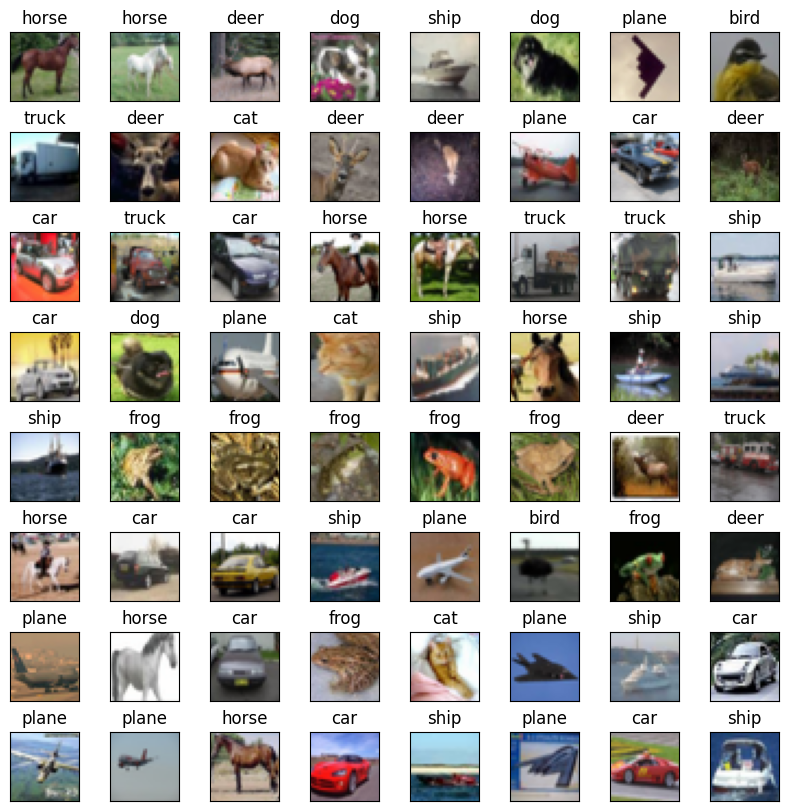

In [3]:
Xtr,ytr = next(iter(trainloader))
# make a 8x8 grid and display 64 images from the first batch of training data
rows,cols = 8,8
fig = plt.figure(figsize=(8,8),constrained_layout=True)

for i in range(0,rows*cols):
    fig.add_subplot(rows,cols,i+1)
    tmp = np.transpose(Xtr[i].numpy(),(1,2,0))
    plt.imshow(((tmp*tstd + tmean)*255).astype(np.uint8))
    plt.xticks([])
    plt.yticks([])
    plt.title(classes[ytr[i].numpy()])

# Accumulate the training, validation, and test sets

In [4]:
def extract_data(generator):
    X = torch.zeros((0,3,32,32))
    y = torch.zeros((0,))
    for (Xtr,ytr) in generator:
        X = torch.vstack([X,Xtr])
        y = torch.concat((y,ytr),axis=0)
    return X,y

Xtrain,ytrain = extract_data(trainloader)
print("Training data: ",Xtrain.shape,ytrain.shape)
Xval,yval = extract_data(valloader)
print("Validation data: ",Xval.shape,yval.shape)
Xtest,ytest = extract_data(testloader)
print("Test data: ",Xtest.shape,ytest.shape)

Training data:  torch.Size([45000, 3, 32, 32]) torch.Size([45000])
Validation data:  torch.Size([5000, 3, 32, 32]) torch.Size([5000])
Test data:  torch.Size([10000, 3, 32, 32]) torch.Size([10000])


# GDA with same covariance for each class (5 points)

Set up an LDA model using sklearn's [LDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) function (10 points)
    
- set up the LinearDiscriminantAnalysis classifier with 'lsqr' solver and store_covariance=True.
- fit this classifier on the training images (flattened into 50000 x 3072) and labels (50000).
- evaluate the trained model with the set aside test set using built in functions from sklearn.metrics: accuracy, confusion matrix, classification report (f1 scores). Remember to flatten the test images before running the .predict() function.
- visualize the means of the 10 classes, and interpret the images in relation to the classes they represent.

In [5]:
# concatenate the train and validation sets for GDA
trainX = torch.vstack((Xtrain,Xval))
trainy = torch.cat([ytrain,yval])
print(trainX.shape,trainy.shape)

torch.Size([50000, 3, 32, 32]) torch.Size([50000])


In [6]:
# your code here (LDA model with same covariance for every class)

# remember to reshape trainX as (50000,3072)
# set up LDA model and fit on (trainX,trainy)
# about 2 lines
trainX_flat = trainX.reshape(trainX.shape[0], -1)
lda = LinearDiscriminantAnalysis(solver='lsqr', store_covariance=True)
lda.fit(trainX_flat, trainy)

LinearDiscriminantAnalysis(solver='lsqr', store_covariance=True)

# Test model on Xtest and ytest (4 points)
- print accuracy of model on (Xtest,ytest)
- print classification report
- print confusion_matrix

In [7]:
#your code here (remember to reshape Xtest)
# about 4 lines
Xtest_flat = Xtest.reshape(Xtest.shape[0], -1)
ypred = lda.predict(Xtest_flat)

print("Accuracy:", accuracy_score(ytest, ypred))
print("Classification Report:\n", classification_report(ytest, ypred, target_names=classes))
print("Confusion Matrix:\n", confusion_matrix(ytest, ypred))

Accuracy: 0.3713
Classification Report:
               precision    recall  f1-score   support

       plane       0.43      0.46      0.45      1000
         car       0.43      0.41      0.42      1000
        bird       0.26      0.26      0.26      1000
         cat       0.25      0.24      0.25      1000
        deer       0.32      0.27      0.29      1000
         dog       0.30      0.33      0.31      1000
        frog       0.38      0.41      0.40      1000
       horse       0.44      0.40      0.42      1000
        ship       0.47      0.49      0.48      1000
       truck       0.42      0.42      0.42      1000

    accuracy                           0.37     10000
   macro avg       0.37      0.37      0.37     10000
weighted avg       0.37      0.37      0.37     10000

Confusion Matrix:
 [[463  44  51  43  23  41  22  51 192  70]
 [ 65 415  44  51  35  46  38  46  80 180]
 [102  37 255 101 133  91 137  71  49  24]
 [ 43  49 122 245  62 214 132  48  30  55]
 [ 61  28

# Visualize the means (1 point)
- comment on the visualizations in this cell. That is, interpret these means in terms of the classes they represent.

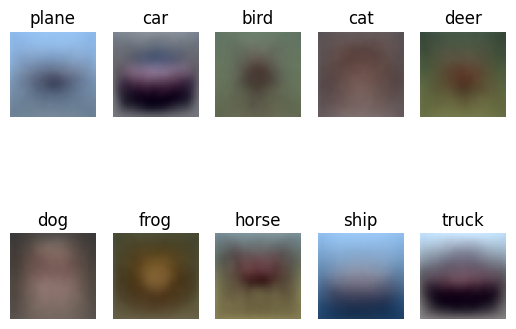

In [8]:
# Run this cell; no code to write.

mean = lda.means_.reshape(10, 32, 32, 3) # 10 x 32 x 32 x 3
class_min, class_max = np.min(lda.means_), np.max(lda.means_)

for i in range(10):
    plt.subplot(2, 5, i + 1)
    tmp = np.transpose(lda.means_[i].reshape((3,32,32)),(1,2,0))
    tmp = (255.0 * (tmp - class_min) / (class_max - class_min)).astype('uint8')
    plt.imshow(tmp)
    plt.axis('off')
    plt.title(classes[i])

plt.show()

# Run SVM on CIFAR10 (40 points)

The sklearn implementation of SVM (SVC) is very slow, because it uses all points in the training set as landmarks. So to speed up the process, we will only use a subset of 5000 images for training.

- build a linear kernel SVC model with probability = False and regularization constant C drawn from a set of values C_vals. For each C, train a linear kernel SVM on the 5000 image training set (sXtrain,sytrain) and measure accuracy on the validation set (Xval,yval). Plot C value vs val set accuracy on a semi-log plot. What is the best value of C for this training set? Build a linear model with that value of C and report accuracy, classification report, and confusion matrix on the full test set.
- build an RBF kernel SVC model with probability = False and regularization constant C drawn from a set of values C_vals. For each C, train an RBF kernel SVM on the 5000 image training set (sXtrain,sytrain) and measure accuracy on the validation set (Xval,yval). Plot C value vs val set accuracy on a semi-log plot. What is the best value of C for this training set? Build an RBF model with that value of C and report accuracy, classification report, and confusion matrix on the full test set.
- Comment on performance differences between the two models, if any.

# Comment on linear SVM vs RBF kernel SVM

Based on the test set performance, compare the accuracy, classification report, and confusion matrix of the linear SVM and RBF kernel SVM. Discuss which model performed better and why that might be the case for this dataset.

In [9]:
# subselect 5000 examples from the CIFAR-10 dataset
N = 5000
sXtrain = trainX[:N]
sytrain = trainy[:N]

In [10]:
# Prepare data for SVM
sXtrain_flat = sXtrain.reshape(sXtrain.shape[0], -1)
Xval_flat = Xval.reshape(Xval.shape[0], -1)
Xtest_flat = Xtest.reshape(Xtest.shape[0], -1)

print("Reshaped training data subset:", sXtrain_flat.shape)
print("Reshaped validation data:", Xval_flat.shape)
print("Reshaped test data:", Xtest_flat.shape)

Reshaped training data subset: torch.Size([5000, 3072])
Reshaped validation data: torch.Size([5000, 3072])
Reshaped test data: torch.Size([10000, 3072])


# Linear SVM kernel
- choosing regularization C using a validation set

In [12]:
C_vals = np.array([0.0001,0.001,0.01,0.1,1,10])
val_accuracies = []

# your code here for fitting and selecting C (about 6 lines)
for C in C_vals:
    linear_svm = LinearSVC(C=C, random_state=42, max_iter=10000)
    linear_svm.fit(sXtrain_flat, sytrain)
    val_pred = linear_svm.predict(Xval_flat)
    accuracy = accuracy_score(yval, val_pred)
    val_accuracies.append(accuracy)
    print(f"C: {C}, Validation Accuracy: {accuracy}")

C: 0.0001, Validation Accuracy: 0.3848
C: 0.001, Validation Accuracy: 0.3444
C: 0.01, Validation Accuracy: 0.2902
C: 0.1, Validation Accuracy: 0.2486
C: 1.0, Validation Accuracy: 0.2276
C: 10.0, Validation Accuracy: 0.2224


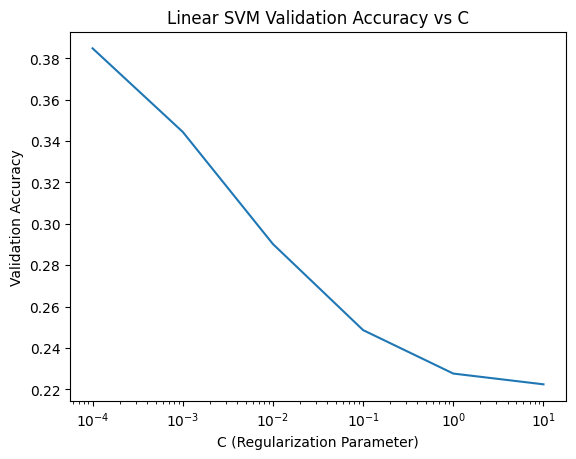

In [13]:
# plot C_vals and val set accuracy in a semilog plot
# 1 line of code
# your code here
plt.semilogx(C_vals, val_accuracies)
plt.xlabel("C (Regularization Parameter)")
plt.ylabel("Validation Accuracy")
plt.title("Linear SVM Validation Accuracy vs C")
plt.show()

In [14]:
# build model with best value of C
# print test accuracy, confusion matrix and classification report on test set
# about 5 lines of code

best_C_linear = C_vals[np.argmax(val_accuracies)]
print(f"Best C for Linear SVM: {best_C_linear}")

linear_svm_best = LinearSVC(C=best_C_linear, random_state=42, max_iter=10000)
linear_svm_best.fit(sXtrain_flat, sytrain)
y_pred_linear = linear_svm_best.predict(Xtest_flat)

print("\nLinear SVM Performance on Test Set:")
print("Accuracy:", accuracy_score(ytest, y_pred_linear))
print("Classification Report:\n", classification_report(ytest, y_pred_linear, target_names=classes))
print("Confusion Matrix:\n", confusion_matrix(ytest, y_pred_linear))

Best C for Linear SVM: 0.0001

Linear SVM Performance on Test Set:
Accuracy: 0.378
Classification Report:
               precision    recall  f1-score   support

       plane       0.43      0.47      0.45      1000
         car       0.36      0.53      0.43      1000
        bird       0.32      0.18      0.23      1000
         cat       0.31      0.17      0.22      1000
        deer       0.37      0.28      0.32      1000
         dog       0.32      0.35      0.33      1000
        frog       0.42      0.43      0.43      1000
       horse       0.40      0.41      0.41      1000
        ship       0.43      0.54      0.48      1000
       truck       0.36      0.42      0.38      1000

    accuracy                           0.38     10000
   macro avg       0.37      0.38      0.37     10000
weighted avg       0.37      0.38      0.37     10000

Confusion Matrix:
 [[472  76  34  16  17  29  22  59 197  78]
 [ 53 528  19  23  16  31  35  48  93 154]
 [122  81 178  52 132 109 121

# RBF SVM kernel
- choosing regularization C using a validation set

In [15]:
C_vals = np.array([0.0001,0.001,0.01,0.1,1,10,100])
val_accuracies_rbf = []

# your code here for finding good value of C for RBF kernel
# about 6 lines
for C in C_vals:
    rbf_svm = SVC(C=C, kernel='rbf', random_state=42)
    rbf_svm.fit(sXtrain_flat, sytrain)
    val_pred_rbf = rbf_svm.predict(Xval_flat)
    accuracy_rbf = accuracy_score(yval, val_pred_rbf)
    val_accuracies_rbf.append(accuracy_rbf)
    print(f"C: {C}, RBF Validation Accuracy: {accuracy_rbf}")

C: 0.0001, RBF Validation Accuracy: 0.0906
C: 0.001, RBF Validation Accuracy: 0.0906
C: 0.01, RBF Validation Accuracy: 0.0914
C: 0.1, RBF Validation Accuracy: 0.3508
C: 1.0, RBF Validation Accuracy: 0.4404
C: 10.0, RBF Validation Accuracy: 0.4532
C: 100.0, RBF Validation Accuracy: 0.4482


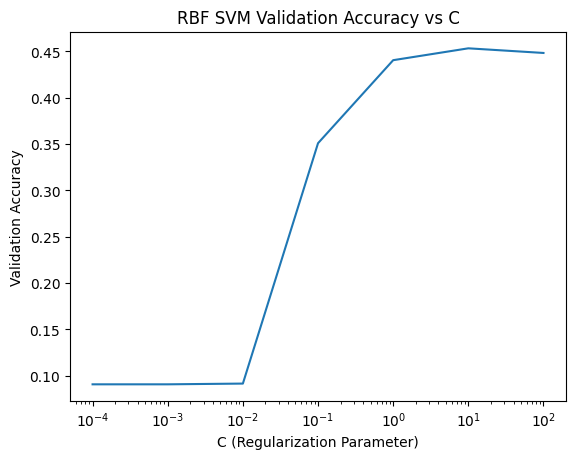

In [16]:
# plot C_vals and val set accuracy in a semilog plot
# 1 line of code
# your code here
plt.semilogx(C_vals, val_accuracies_rbf)
plt.xlabel("C (Regularization Parameter)")
plt.ylabel("Validation Accuracy")
plt.title("RBF SVM Validation Accuracy vs C")
plt.show()

In [17]:
# your code here
# build best RBF model with best value of C
# report test set accuracy, confusion matrix and classification report on test set
# about 6 lines of code

best_C_rbf = C_vals[np.argmax(val_accuracies_rbf)]
print(f"Best C for RBF SVM: {best_C_rbf}")

rbf_svm_best = SVC(C=best_C_rbf, kernel='rbf', random_state=42)
rbf_svm_best.fit(sXtrain_flat, sytrain)
y_pred_rbf = rbf_svm_best.predict(Xtest_flat)

print("\nRBF SVM Performance on Test Set:")
print("Accuracy:", accuracy_score(ytest, y_pred_rbf))
print("Classification Report:\n", classification_report(ytest, y_pred_rbf, target_names=classes))
print("Confusion Matrix:\n", confusion_matrix(ytest, y_pred_rbf))

Best C for RBF SVM: 10.0

RBF SVM Performance on Test Set:
Accuracy: 0.4394
Classification Report:
               precision    recall  f1-score   support

       plane       0.50      0.53      0.51      1000
         car       0.50      0.58      0.54      1000
        bird       0.31      0.32      0.32      1000
         cat       0.29      0.31      0.30      1000
        deer       0.40      0.38      0.39      1000
         dog       0.34      0.33      0.33      1000
        frog       0.50      0.45      0.48      1000
       horse       0.50      0.45      0.47      1000
        ship       0.58      0.59      0.58      1000
       truck       0.49      0.46      0.48      1000

    accuracy                           0.44     10000
   macro avg       0.44      0.44      0.44     10000
weighted avg       0.44      0.44      0.44     10000

Confusion Matrix:
 [[528  60  68  30  42  21  19  27 144  61]
 [ 49 578  28  42  13  38  15  30  72 135]
 [ 99  29 320  91 165  83  86  74  2

# Comment on linear SVM vs RBF kernel SVM


Comparing the test set performance of the linear SVM (Best C: 0.0001) and the RBF kernel SVM (Best C: 10.0):

**Accuracy:**
- Linear SVM Test Accuracy: 0.378
- RBF SVM Test Accuracy: 0.4394

The RBF kernel SVM achieved a higher overall accuracy on the test set compared to the linear SVM.

**Classification Report:**
- For the Linear SVM, the precision, recall, and f1-scores vary across classes, with some classes like 'car' and 'ship' having relatively higher recall, while others like 'bird' and 'cat' have lower recall.
- For the RBF SVM, the precision, recall, and f1-scores are generally higher across most classes compared to the linear SVM, indicating better performance in classifying individual classes.

**Confusion Matrix:**
- The confusion matrix for the Linear SVM shows a significant number of misclassifications between similar classes. For example, there are many instances where 'car' is misclassified as 'truck', and vice versa.
- The confusion matrix for the RBF SVM shows fewer misclassifications compared to the linear SVM, with higher values along the diagonal (correct classifications). However, there are still some confusions between similar classes, though generally less pronounced than with the linear kernel.

**Performance Discussion:**

The RBF kernel SVM performed better than the linear SVM on this dataset. This is likely because the CIFAR-10 dataset is complex and not linearly separable in its original pixel space. The RBF kernel implicitly maps the data into a higher-dimensional space where it may become linearly separable, allowing the SVM to find a more effective decision boundary. Linear SVM, on the other hand, is limited to finding a linear decision boundary in the original feature space, which is insufficient for this dataset. The non-linear nature of the RBF kernel allows it to capture more complex relationships between the features, leading to improved classification performance.